In [24]:
import math
import torch
from pykeops.torch import LazyTensor
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [25]:
def rbf(sigma, device, X1, X2=None):
    x1_lazy = LazyTensor(X1[:, None, :])
    if X2 is None:
        x2_lazy = LazyTensor(X1[None, :, :])
    else:
        x2_lazy = LazyTensor(X2[None, :, :])

    D = ((x1_lazy - x2_lazy) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    identity_shape = X1.shape[0] if X2 is None else X2.shape[0]
    return K @ torch.eye(identity_shape, device=device)

In [26]:
torch.manual_seed(0)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# m = 10000
# d = 20
sigma = 10.0
delta = 0.01
lambd = 1.0
n_components = 100
# X = torch.randn(m, d, device=device)

# Load data and standardize
X, y = load_svmlight_file("../data/cod-rna")
X = X.toarray()
X = X[:5000, :] # Subsample
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, device=device, dtype=torch.float32)

# kernel_fn = lambda Y: rbf(sigma, device, Y, None)

def kernel_fn(Y1, Y2=None):
    return rbf(sigma, device, Y1, Y2)

### Alg. 2 from "Recursive Sampling for the Nyström Method" by Musco & Musco (2017)

In [29]:
def rrls_nystrom2(X, kernel_fn, lambd, delta, device):
    m, _ = X.shape
    print(f"m ub = {192 * torch.log(1/delta)}")
    if m <= 192 * torch.log(1 / delta):
        return torch.eye(m, device=device)
    
    # Sample rows of X independently, each with probability 1/2
    S_bar = torch.bernoulli(0.5 * torch.ones(m, device=device)).bool()
    S_bar_mat = torch.zeros(m, torch.sum(S_bar), device=device)
    S_bar_mat[S_bar, torch.arange(torch.sum(S_bar))] = 1
    S_til = rrls_nystrom2(X[S_bar], kernel_fn, lambd, delta / 3, device)
    print(f"S_bar_mat.shape = {S_bar_mat.shape}")
    print(f"S_til.shape = {S_til.shape}")
    S_hat = S_bar_mat @ S_til # TODO(pratik): Try making this more efficient in the future

    # Compute approximate leverage scores
    K = kernel_fn(X)
    S_hatT_K = S_hat.T @ K
    C = S_hatT_K @ S_hat # TODO(pratik): optimize this -- think of it as taking the block kernel followed by column/row scaling
    C.diagonal().add_(lambd)
    L = torch.linalg.cholesky(C)
    nys_sqrt = torch.linalg.solve_triangular(L, S_hatT_K, upper=False)

    l_tilde = 3/(2 * lambd) * (torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))
    print(f"min of unscaled leverage scores = {torch.min(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
    print(f"max of unscaled leverage scores = {torch.max(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
    adj_factor = torch.log(torch.sum(l_tilde) / delta)
    print(
        f"min of adjusted leverage scores = {torch.min(adj_factor * l_tilde)}")
    p = torch.minimum(torch.ones(m, device=device), adj_factor * l_tilde)
    # print(f"min of adjusted leverage scores = {torch.min(16 * adj_factor * l_tilde)}")
    # p = torch.minimum(torch.ones(m, device=device), 16 * adj_factor * l_tilde)

    # Form the new sampling matrix
    sampling_vector = torch.bernoulli(p)
    # Find indices of sampling_vector that equal 1
    sampling_indices = torch.nonzero(sampling_vector == 1).squeeze()
    num_columns = sampling_indices.shape[0]
    S = torch.zeros(m, num_columns, device=device)
    S[sampling_indices, torch.arange(num_columns)] = 1 / torch.sqrt(p[sampling_indices])
    return S

### Alg. 3 from "Recursive Sampling for the Nyström Method" by Musco & Musco (2017)

In [30]:
def rrls_nystrom3(X, n_components, kernel_fn, device, accelerated=False, lambd_0=0, return_leverage_scores=False):
    n_oversample = torch.log(n_components)
    k = torch.ceil(n_components / (4 * n_oversample)).int()
    n_levels = torch.ceil(torch.log2(X.shape[0] / n_components)).int()
    perm = torch.randperm(X.shape[0])

    # Set up sizes for recursive levels
    size_list = [X.shape[0]]
    for _ in range(n_levels):
        size_list.append(math.ceil(size_list[-1] / 2))

    # Indices of points selected at previous level of recursion
    # At the base level it's just a uniform sample of ~ n_components points
    sample = torch.arange(size_list[-1])
    indices = perm[sample]
    weights = torch.ones(indices.shape[0], device=device)

    # Compute whole diagonal of kernel matrix
    K_diag = kernel_fn(X).diagonal()

    # Main recursion, unrolled for efficiency
    for l in reversed(range(n_levels)):
        # Indices of current uniform sample
        current_indices = perm[:size_list[l]]

        # Build sampled kernel matrix
        KS = kernel_fn(X[current_indices, :], X[indices, :])
        SKS = KS[sample, :]

        # Optimal lambda for taking O(klog(k)) samples
        if k >= SKS.shape[0]:
            # For the rare chance we take less than k samples in a round
            # Don't set to exactly 0 to avoid stability issues
            lambd = 1e-5
        else:
            # Eigenvalues equal roughly the number of points per cluster, maybe this should scale with n?
            # Can be interpreted as the zoom level
            # TODO(pratik): use lobpcg to compute the top k eigenvalues
            lambd = (torch.sum(SKS.diagonal() * (weights ** 2)) 
                     - torch.sum(torch.linalg.eigvalsh(SKS * weights[:, None] * weights[None, :])[:k]))/k
        lambd = max(lambd_0 * SKS.shape[0], lambd)

        # Compute and sample by lambd ridge leverage scores
        SKS.diagonal().add_(lambd * (weights ** (-2)))
        R = torch.linalg.inv(SKS) # TODO(pratik): use cholesky here
        R = KS @ R
        if l > 0:
            # max(0, .) is to avoid numerical issues, unnecessary in theory
            leverage_score = torch.minimum(torch.tensor([1.], device=device), n_oversample * (1/ lambd) * torch.relu(
                                (K_diag[current_indices] - torch.sum(R * KS, dim=1))))
            # On intermediate levels, we independently sample each column
            # by its leverage score. The sample size is n_components in expectation
            sample = torch.bernoulli(leverage_score).bool()
            sample = torch.arange(current_indices.shape[0], device=device)[sample]
            # With very low probabiltity, we could accidentally sample no
            # Columns. In this case, just take a fixed size uniform sample
            if torch.sum(sample) == 0:
                leverage_score = torch.ones(current_indices.shape[0], device=device) * n_components / current_indices.shape[0]
                sample = torch.randperm(current_indices.shape[0])[:n_components]
            weights = 1 / torch.sqrt(leverage_score[sample])
        else:
            leverage_score = torch.minimum(torch.tensor([1.], device=device), (1 / lambd) * torch.relu(
                                (K_diag[current_indices] - torch.sum(R * KS, dim=1))))
            p = leverage_score / torch.sum(leverage_score)
            sample = torch.multinomial(p, int(n_components.item()), replacement=False)
        indices = perm[sample]

    if return_leverage_scores:
        return indices, leverage_score[torch.argsort(perm)]
    else:
        return indices

### Try out RRLS methods

In [31]:
# S = rrls_nystrom2(X, kernel_fn, lambd, torch.tensor([delta], device=device), device)

In [32]:
# S

In [33]:
# S.shape

In [34]:
indices_rrls, leverage_scores_rrls = rrls_nystrom3(X, torch.tensor([n_components]), kernel_fn, device, return_leverage_scores=True)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,1,2), d=Var(3,9,1) ... OK
[pyKeOps] Compiling pykeops cpp 048c84488a module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,1,2), d=Var(3,16,1) ... OK
[pyKeOps] Compiling pykeops cpp fdcda683f2 module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,1,2), d=Var(3,8,1) ... OK
[pyKeOps] Compiling pykeops cpp 17926b869d module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,1,2), d=Var(3,26,1) ... OK
[pyKeOps] Compiling pykeops cpp 0ed9049078 module ... OK


In [35]:
# indices_rrls

In [36]:
# leverage_scores_rrls

In [37]:
# plt.hist(leverage_scores_rrls.cpu().numpy(), bins=100)

In [38]:
def nystrom(X, indices, kernel_fn, device):
    C = kernel_fn(X[indices], X[indices])
    shift = 1e-5
    C.diagonal().add_(shift) # For stability
    KS = kernel_fn(X, X[indices])

    L = torch.linalg.cholesky(C)
    nys_sqrt = torch.linalg.solve_triangular(L, KS.T, upper=False)
    _, S, VT = torch.linalg.svd(nys_sqrt, full_matrices=False)
    S = torch.max(torch.tensor([0.], device=device), S ** 2 - shift)

    return VT.T @ torch.diag(S) @ VT

In [39]:
K_rrls = nystrom(X, indices_rrls, kernel_fn, device)

# Sample indices uniformly at random
indices_rand = torch.randperm(X.shape[0])[:n_components]
K_rand = nystrom(X, indices_rand, kernel_fn, device)

# Full kernel matrix
K_full = kernel_fn(X)
# Compute eigendecomposition of full kernel matrix
eigvals, eigvecs = torch.linalg.eigh(K_full)
eigvals_trunc = eigvals[-n_components:]
eigvecs_trunc = eigvecs[:, -n_components:]
K_lr = eigvecs_trunc @ torch.diag(eigvals_trunc) @ eigvecs_trunc.T

# Compute spectral norm of difference between approximations and K_full
rrls_err = torch.linalg.norm(K_rrls - K_full, ord=2)
rand_err = torch.linalg.norm(K_rand - K_full, ord=2)

print(f"RRLS error = {rrls_err}")
print(f"Random error = {rand_err}")

RRLS error = 0.04152042791247368
Random error = 0.8579890131950378


### Compute exact leverage scores

In [40]:
def leverage_scores(K, lambd):
    L = torch.linalg.cholesky(K + lambd * torch.eye(K.shape[0], device=device))

    # L^-T L^-1 K
    L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
    LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

    leverage_scores = torch.diagonal(LT_inv_L_inv_K)

    return leverage_scores

In [41]:
def eff_dim(K, lambd):
    eigs_K_reg = torch.linalg.eigvalsh(K)
    return torch.sum(eigs_K_reg / (eigs_K_reg + lambd))

In [42]:
# K = rbf(sigma, device, X)
# L = torch.linalg.cholesky(K + lambd * torch.eye(X.shape[0], device=device))

# # L^-T L^-1 K
# L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
# LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

# leverage_scores = torch.diagonal(LT_inv_L_inv_K)

leverage_scores_full = leverage_scores(K_full, lambd)
leverage_scores_rrls = leverage_scores(K_rrls, lambd)
leverage_scores_rand = leverage_scores(K_rand, lambd)

(array([1.263e+03, 1.600e+03, 8.490e+02, 3.990e+02, 2.490e+02, 1.830e+02,
        1.150e+02, 8.800e+01, 4.900e+01, 2.800e+01, 2.800e+01, 9.000e+00,
        1.300e+01, 1.500e+01, 1.000e+01, 1.600e+01, 1.600e+01, 6.000e+00,
        6.000e+00, 1.000e+00, 1.200e+01, 6.000e+00, 4.000e+00, 7.000e+00,
        2.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

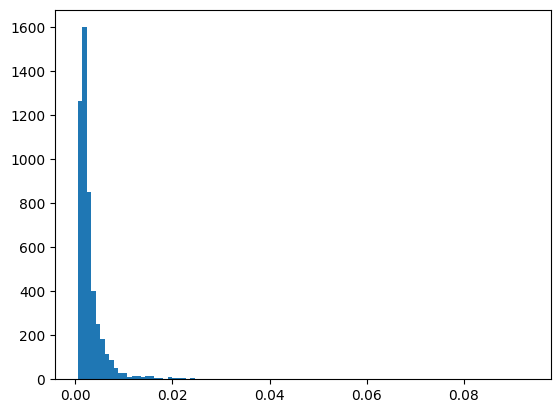

In [43]:
plt.hist(leverage_scores_full.cpu().numpy(), bins=100)

(array([1.015e+03, 1.569e+03, 9.160e+02, 4.710e+02, 2.680e+02, 2.000e+02,
        1.380e+02, 1.020e+02, 7.300e+01, 4.100e+01, 2.700e+01, 2.400e+01,
        1.400e+01, 1.200e+01, 8.000e+00, 1.300e+01, 1.400e+01, 1.300e+01,
        1.200e+01, 7.000e+00, 3.000e+00, 3.000e+00, 8.000e+00, 1.000e+01,
        5.000e+00, 3.000e+00, 9.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

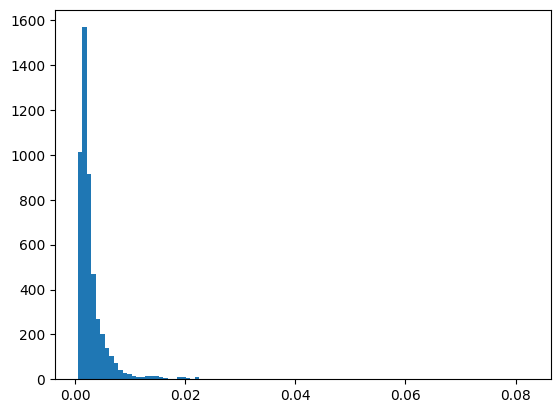

In [44]:
plt.hist(leverage_scores_rrls.cpu().numpy(), bins=100)

(array([1.115e+03, 1.580e+03, 9.060e+02, 4.510e+02, 2.450e+02, 2.060e+02,
        1.190e+02, 1.010e+02, 5.200e+01, 3.300e+01, 3.400e+01, 1.500e+01,
        1.200e+01, 1.600e+01, 1.000e+01, 1.500e+01, 1.600e+01, 8.000e+00,
        4.000e+00, 6.000e+00, 1.100e+01, 4.000e+00, 6.000e+00, 2.000e+00,
        6.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

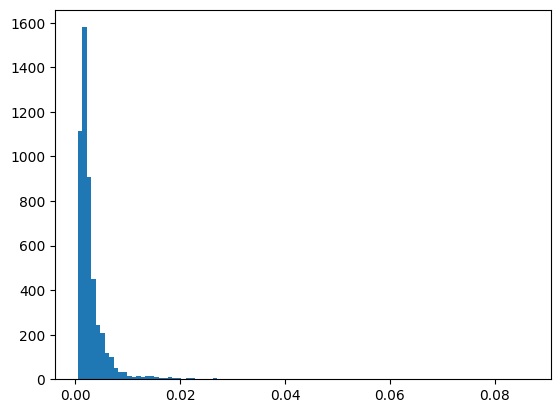

In [45]:
plt.hist(leverage_scores_rand.cpu().numpy(), bins=100)

In [46]:
eff_dim_full = eff_dim(K_full, lambd)
eff_dim_rrls = eff_dim(K_rrls, lambd)
eff_dim_rand = eff_dim(K_rand, lambd)

print(f"Effective dimension of full kernel matrix = {eff_dim_full}")
print(f"Effective dimension of RRLS approximation = {eff_dim_rrls}")
print(f"Effective dimension of random approximation = {eff_dim_rand}")

Effective dimension of full kernel matrix = 15.328604698181152
Effective dimension of RRLS approximation = 15.117136001586914
Effective dimension of random approximation = 14.944564819335938
